In [69]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 
import os
import copy as cp

## Functions

In [34]:
def add_padding(img, block_size):
    h,w = img.shape
    if h % block_size != 0:
        h = h + (block_size - h % block_size)
    if w % block_size != 0:
        w = w + (block_size - w % block_size)
    img = cv2.copyMakeBorder(img, 0, h - img.shape[0], 0, w - img.shape[1], cv2.BORDER_CONSTANT, value=0)
    return img

In [35]:
def block_split(img, block_size):
    h, w = img.shape
    return [img[i:i+block_size, j:j+block_size] for i in range(0, h, block_size) for j in range(0, w, block_size)]

In [36]:
def lzw_encode(img_blocks, Codes):
    decoded = []
    for block in img_blocks:
        block = block.flatten()
        dictionary = {chr(i): i for i in range(256)}
        w = ''
        result = []
        for c in block:
            wc = w + chr(c)
            if wc in dictionary:
                w = wc
            else:
                result.append(dictionary[w])
                if len(dictionary) < Codes:
                    dictionary[wc] = len(dictionary)
                w = chr(c)
        if w:
            result.append(dictionary[w])
        decoded.append(result)
    return decoded, len(dictionary)-1

In [37]:
def lzw_decode(encoded_blocks, block_size):
    decoded = []
    for block in encoded_blocks:
        dictionary = {i: chr(i) for i in range(256)}
        w = chr(block.pop(0))
        result = w
        for k in block:
            if k in dictionary:
                entry = dictionary[k]
            elif k == len(dictionary):
                entry = w + w[0]
            result += entry
            dictionary[len(dictionary)] = w + entry[0]
            w = entry
        decoded.append(np.array([ord(c) for c in result]).reshape(block_size, block_size))
    return decoded
        


In [38]:
def block_join(decoded_blocks, img, block_size):
    h, w = img.shape
    blocks_per_row = w // block_size
    blocks_per_col = h // block_size
    blocks = []
    for i in range(blocks_per_col):
        row = []
        for j in range(blocks_per_row):
            row.append(decoded_blocks[i*blocks_per_row + j])
        blocks.append(np.hstack(row))
    return np.vstack(blocks)

## Image Encoding

In [77]:
def LZW_encoder(filename,block_size,Codes=4096):
    img = cv2.imread(filename, 0)
    if block_size == -1:
        block_size = max(img.shape)
    img = add_padding(img, block_size)
    img_blocks = block_split(img, block_size)
    encoded_blocks, max_size = lzw_encode(img_blocks,Codes)
    count = 0
    for block in encoded_blocks:
        count+=len(block)
    CR = (img.shape[0]*img.shape[1])/count
    if not os.path.exists('lzw_encoded_text'):
        os.mkdir('lzw_encoded_text')
    with open('lzw_encoded_text/lzw_encoded_'+str(filename)[7:-4]+'.txt', 'w') as f:
        f.write(str(img.shape[0]) + ' ' + str(img.shape[1]) + ' '+str(block_size)+'\n')
        for block in encoded_blocks:
            f.write(str(block) + '\n')
    freq = {}
    count = 0
    for block in encoded_blocks:
        for i in block:
            count+=1
            if i in freq:
                freq[i] += 1
            else:
                freq[i] = 1
    entropy = 0
    for key in freq:
        entropy+=freq[key]/count*np.log2(count/freq[key])
    return encoded_blocks, max_size, CR, entropy

## Image Decoding

In [78]:
def  LZW_decoder(filename):
    with open(filename, 'r') as f:
        h, w, block_size = [int(x) for x in f.readline().split()]
        encoded_blocks = []
        for line in f:
            encoded_blocks.append([int(x) for x in line.strip('[]\n').split(',')])
    decoded_blocks = lzw_decode(encoded_blocks, block_size)
    img = block_join(decoded_blocks, np.zeros((h, w)), block_size)
    return img


## Analysis


In [93]:
import os
points_CR = {}
points_x = [1,2,3,4,5,6,7,8,9,10,11,12]
blocks_x = [2,4,8,16,32,64,128,256,-1]
points_Entropy = {}
points_max = {}
for i in blocks_x:
    points_CR[i] = []
    points_Entropy[i] = []
    points_max[i] = []

for file in os.listdir(os.path.join(os.getcwd(), 'images')):
    if file.endswith('.png'):
        for block_size in blocks_x:
            img = cv2.imread('images/'+str(file), 0)
            print("Original Image Size: ", img.shape)
            encoded_blocks, max_size, CR, entropy = LZW_encoder('images/'+str(file), block_size)
            print("Compression Ratio: ", CR)
            points_CR[block_size].append(CR)
            print("Max Code size used: ", max_size)
            points_max[block_size].append(max_size)
            print("Entropy: ", entropy)
            points_Entropy[block_size].append(entropy)
            img = LZW_decoder('lzw_encoded_text/lzw_encoded_'+str(file)[:-4]+'.txt')
            print("Decoded Image Size: ", img.shape)
            if not os.path.exists('lzw_decoded_images'):
                os.mkdir('lzw_decoded_images')
            cv2.imwrite('lzw_decoded_images/lzw_decoded_'+str(file), img)
            print()

Original Image Size:  (512, 768)
Compression Ratio:  1.0206112517033288
Max Code size used:  258
Entropy:  6.710473968088097
Decoded Image Size:  (512, 768)

Original Image Size:  (512, 768)
Compression Ratio:  1.065507626523882
Max Code size used:  268
Entropy:  6.837779617620772
Decoded Image Size:  (512, 768)

Original Image Size:  (512, 768)
Compression Ratio:  1.1196929227580001
Max Code size used:  304
Entropy:  7.050394934361626
Decoded Image Size:  (512, 768)

Original Image Size:  (512, 768)
Compression Ratio:  1.1929481792504635
Max Code size used:  416
Entropy:  7.427279207864884
Decoded Image Size:  (512, 768)

Original Image Size:  (512, 768)
Compression Ratio:  1.3121590010378048
Max Code size used:  905
Entropy:  8.147296413278728
Decoded Image Size:  (512, 768)

Original Image Size:  (512, 768)
Compression Ratio:  1.5038723519805408
Max Code size used:  2753
Entropy:  9.39053966668024
Decoded Image Size:  (512, 768)

Original Image Size:  (512, 768)
Compression Ratio:  

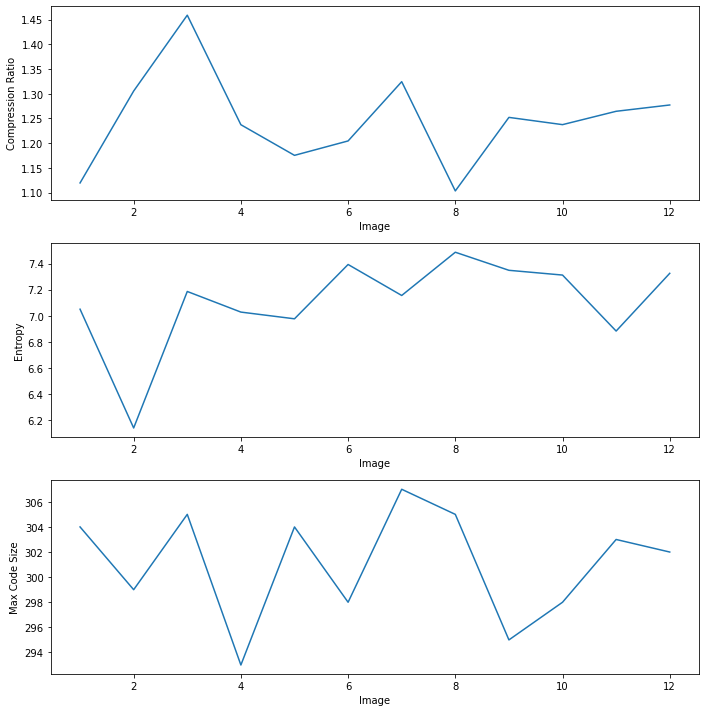

In [120]:
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.plot(points_x, points_CR[8])
plt.xlabel('Image')
plt.ylabel('Compression Ratio')
plt.subplot(3,1,2)
plt.plot(points_x, points_Entropy[8])
plt.xlabel('Image')
plt.ylabel('Entropy')
plt.subplot(3,1,3)
plt.plot(points_x, points_max[8])
plt.xlabel('Image')
plt.ylabel('Max Code Size')
plt.tight_layout()
plt.show()

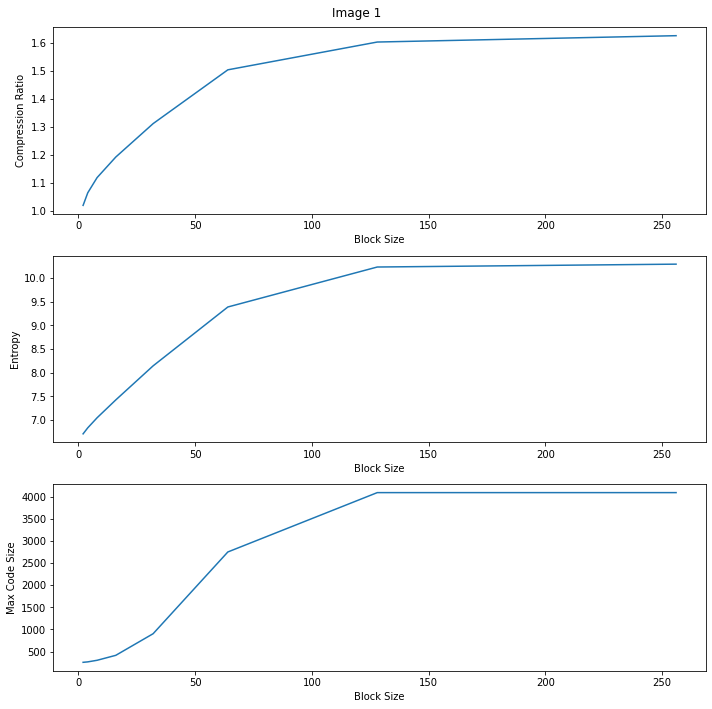

In [121]:
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
temp = list(points_CR.keys())
temp.remove(-1)
plt.plot(temp, [points_CR[i][0] for i in temp])
plt.xlabel('Block Size')
plt.ylabel('Compression Ratio')
plt.subplot(3,1,2)
plt.plot(temp, [points_Entropy[i][0] for i in temp])
plt.xlabel('Block Size')
plt.ylabel('Entropy')
plt.subplot(3,1,3)
plt.plot(temp, [points_max[i][0] for i in temp])
plt.xlabel('Block Size')
plt.ylabel('Max Code Size')
plt.suptitle('Image 1')
plt.tight_layout()
plt.show()

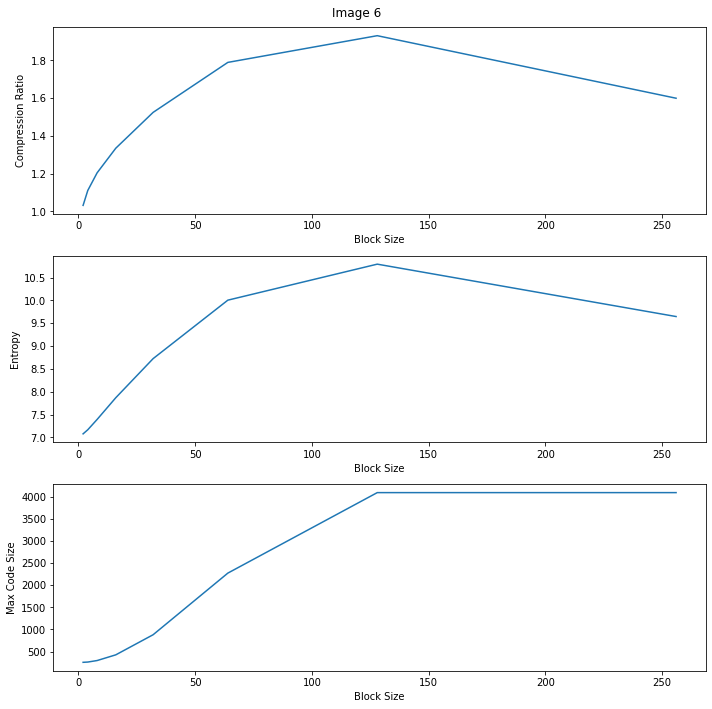

In [122]:
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
temp = list(points_CR.keys())
temp.remove(-1)
plt.plot(temp, [points_CR[i][5] for i in temp])
plt.xlabel('Block Size')
plt.ylabel('Compression Ratio')
plt.subplot(3,1,2)
plt.plot(temp, [points_Entropy[i][5] for i in temp])
plt.xlabel('Block Size')
plt.ylabel('Entropy')
plt.subplot(3,1,3)
plt.plot(temp, [points_max[i][5] for i in temp])
plt.xlabel('Block Size')
plt.ylabel('Max Code Size')
plt.suptitle('Image 6')
plt.tight_layout()
plt.show()

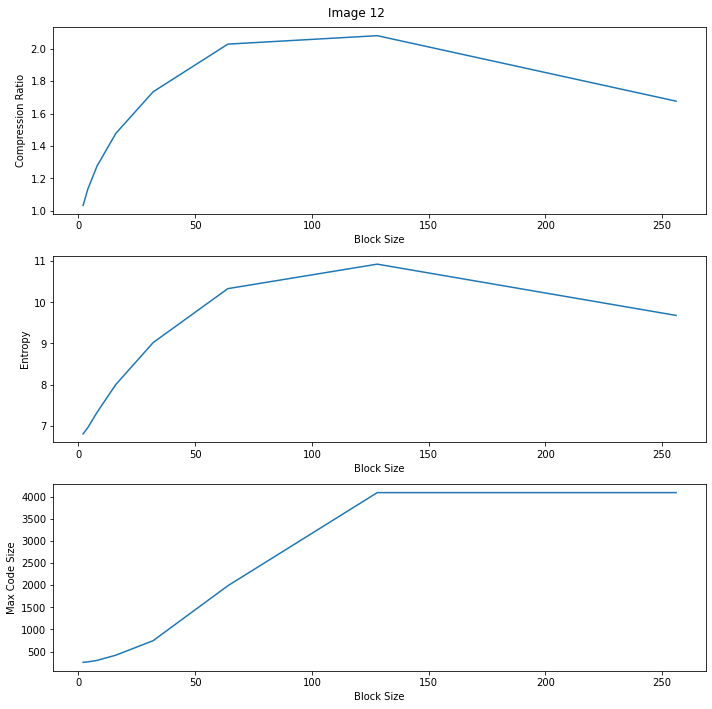

In [123]:
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
temp = list(points_CR.keys())
temp.remove(-1)
plt.plot(temp, [points_CR[i][11] for i in temp])
plt.xlabel('Block Size')
plt.ylabel('Compression Ratio')
plt.subplot(3,1,2)
plt.plot(temp, [points_Entropy[i][11] for i in temp])
plt.xlabel('Block Size')
plt.ylabel('Entropy')
plt.subplot(3,1,3)
plt.plot(temp, [points_max[i][11] for i in temp])
plt.xlabel('Block Size')
plt.ylabel('Max Code Size')
plt.suptitle('Image 12')
plt.tight_layout()
plt.show()